# E18: OCR을 활용하여  음식점 간판 읽기
#### 루브릭

1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?   
목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.
2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?   
평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.
3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?   
최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

## Step1. 검증용 데이터셋 준비
- 텍스트의 모양과 크기, 배치, 노이즈가 OCR의 성능에 주는 영향을 알아보기 위해 다양한 이미지를 데이터셋으로 활용한다.
- 다양한 이미지를 9개 준비하였다.

In [1]:
import os

img_dir = os.getenv('HOME')+'/aiffel/data_files/restaurants'
restaurants = os.listdir(img_dir)
restaurants

['big_small_letters.jfif',
 'below.jpg',
 'round.jpg',
 'easy_to_read.jfif',
 'thick_letters.jfif',
 'tilted_1.jpg',
 'tilted_2.jfif',
 'vertical.jpg']

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
- 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

### 1. keras-ocr

In [2]:
import matplotlib.pyplot as plt
import keras_ocr

In [3]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
# 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러온다.
pipeline = keras_ocr.pipeline.Pipeline()

images = [keras_ocr.tools.read(os.path.join(img_dir, restaurant)) for restaurant in restaurants]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, restaurant)]) for restaurant in restaurants]

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


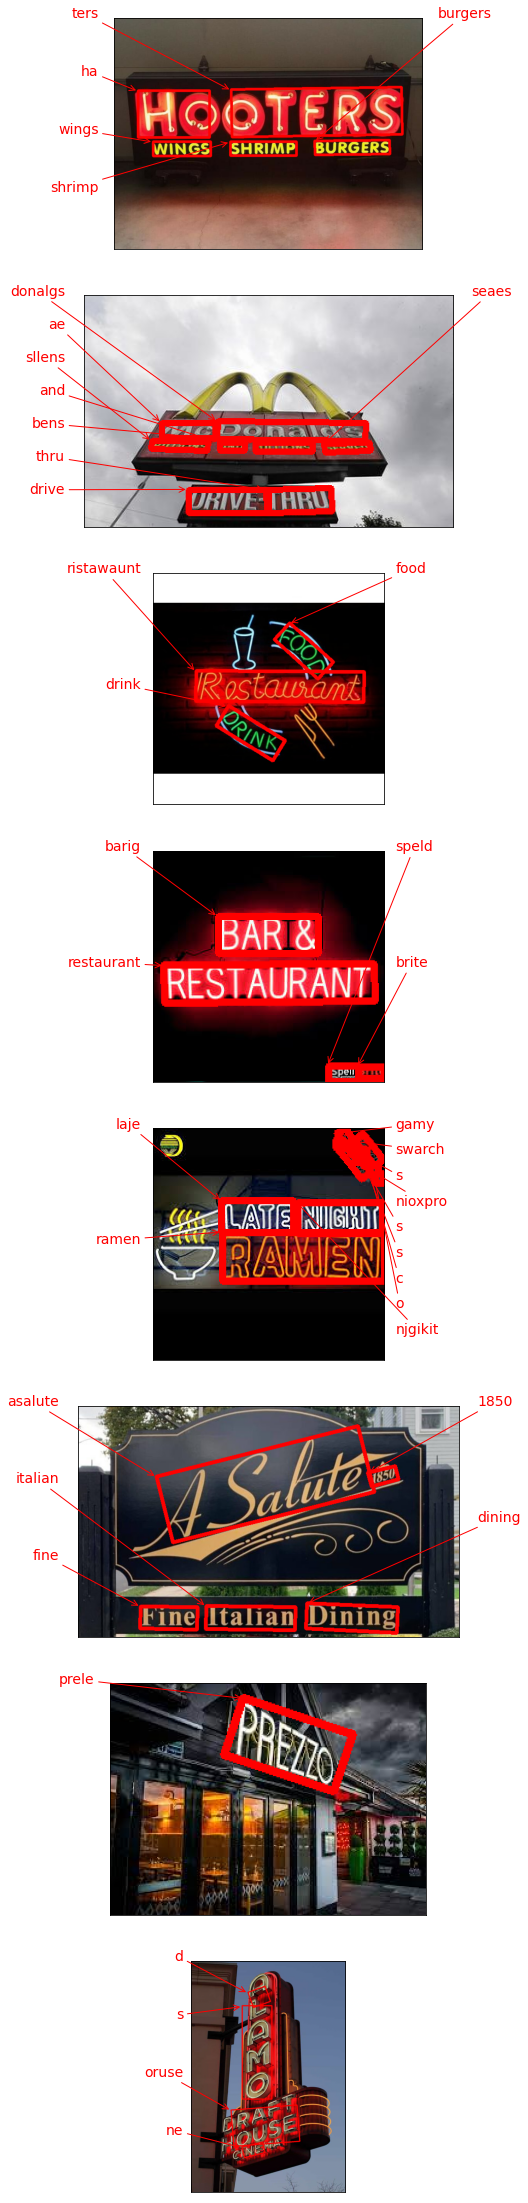

In [4]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(40, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 2. tesseract OCR

In [5]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

In [6]:
def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [7]:
save_dir = os.getenv('HOME')+'/aiffel/data_files/restaurants/'

for restaurant in restaurants:
    print(f'[{restaurant}]')
    try:
        recognize_images(os.path.join(img_dir, restaurant), save_dir)
    except:
        print(f'Cannot recognize characters from {restaurant}')

[big_small_letters.jfif]
Ted

WINGS

SHRIMP

BURGERS

Done
[below.jpg]
Lr

- 42a!

ay

C+

mre.

a!

~~ © \

oe


—_—

Done
[round.jpg]
Cannot recognize characters from round.jpg
[easy_to_read.jfif]
FN cares

NL

Pye eeev el

Done
[thick_letters.jfif]
=a REE

Done
[tilted_1.jpg]

HITS

itearen

ay

Bie

|

Done
[tilted_2.jfif]
Cannot recognize characters from tilted_2.jfif
[vertical.jpg]
a4

Done


### 3. 구글 OCR

In [8]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [9]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'


# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for restaurant in restaurants:
    print(f'[{restaurant}]')
    detect_text(os.path.join(img_dir, restaurant))
    print()

total 176868
-rw-r--r-- 1 root root     4645 Aug 24 09:10 attention.py
-rw-r--r-- 1 root root 12491119 Sep 14 14:31 고해상도_bicubic.gif
drwxr-xr-x 2 root root     4096 Sep  9 09:05 data
-rw-r--r-- 1 root root   160853 Aug 24 11:53 e10_summarizing_news.ipynb
-rw-r--r-- 1 root root   368454 Aug 26 01:51 e11_pneumonia_diagnosis.ipynb
-rw-r--r-- 1 root root   108208 Aug 31 14:02 e12_movie_choice_prediction.ipynb
-rw-r--r-- 1 root root   412360 Sep  2 05:05 e13_creating_CIFAR-10_image.ipynb
-rw-r--r-- 1 root root    18168 Sep  2 05:04 e13.ipynb
-rw-r--r-- 1 root root   957257 Sep  7 11:50 e14_stock_prediction.ipynb
-rw-r--r-- 1 root root    50936 Sep  9 09:56 e15_korean_chatbot.ipynb
-rw-r--r-- 1 root root  4796559 Sep 14 14:52 e16.ipynb
-rw-r--r-- 1 root root 45319319 Sep 17 05:54 e16_srgan.ipynb
-rw-r--r-- 1 root root   655946 Sep 16 14:28 e17_bert_pretained_model.ipynb
-rw-r--r-- 1 root root     5977 Sep 15 07:09 e17.ipynb
-rw-r--r-- 1 root root    12007 Sep 21 08:24 e18_OCR.ipynb
-rw-r--r-

### Step3. 테스트 결과 정리
- 비교하는 함수 만들어주기

In [10]:
def compare_ocr(restaurant):
    print('[keras-ocr]')
    idx = restaurants.index(restaurant)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('[Google OCR]')
    detect_text(os.path.join(img_dir, restaurant))
    print('[Tesseract]')
    recognize_images(os.path.join(img_dir, restaurant), save_dir)

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


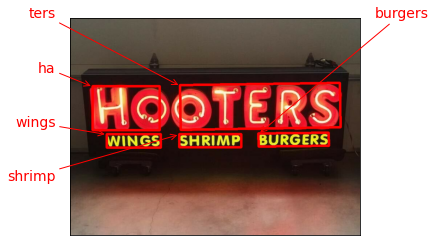

[Google OCR]
Texts:

"HOOTERS
WINGS
SHRIMP
BURGERS
"

"HOOTERS"

"WINGS"

"SHRIMP"

"BURGERS"
bounds: (522,322),(710,321),(710,351),(522,352)
[Tesseract]
Ted

WINGS

SHRIMP

BURGERS

Done


In [11]:
compare_ocr('big_small_letters.jfif')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


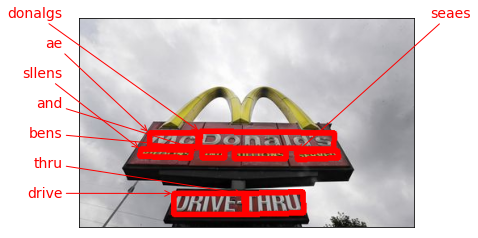

[Google OCR]
Texts:

"McDonald's
BILLIONS
AND BILLIONS
SERVED
DRIVE-THRU
"

"McDonald's"

"BILLIONS"

"AND"

"BILLIONS"

"SERVED"

"DRIVE-THRU"
bounds: (109,215),(280,215),(280,240),(109,240)
[Tesseract]
Lr

- 42a!

ay

C+

mre.

a!

~~ © \

oe


—_—

Done


In [12]:
compare_ocr('below.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


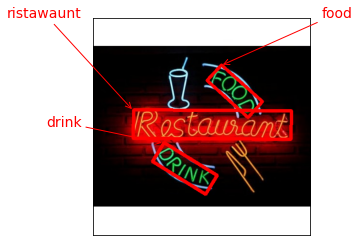

[Google OCR]
Texts:

"Rostaurant
ORINK
FOOD
"

"Rostaurant"

"ORINK"

"FOOD"
bounds: (265,89),(349,177),(304,221),(219,133)
[Tesseract]


SystemError: tile cannot extend outside image

In [13]:
compare_ocr('round.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


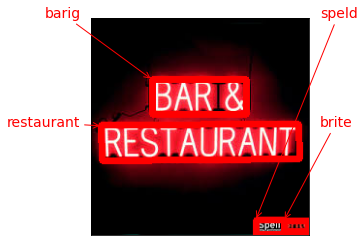

[Google OCR]
Texts:

"BAR &
RESTAURANT
Spell Brite
"

"BAR"

"&"

"RESTAURANT"

"Spell"

"Brite"
bounds: (201,209),(223,208),(223,221),(201,222)
[Tesseract]
FN cares

NL

Pye eeev el

Done


In [14]:
compare_ocr('easy_to_read.jfif')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


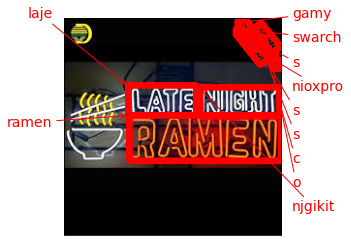

[Google OCR]
Texts:

"LATE NIGHT
RAMEN
Search
Gamystye neon
In Aliexpress
"

"LATE"

"NIGHT"

"RAMEN"

"Search"

"Gamystye"

"neon"

"In"

"Aliexpress"
bounds: (187,16),(214,49),(208,54),(181,21)
[Tesseract]
=a REE

Done


In [15]:
compare_ocr('thick_letters.jfif')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


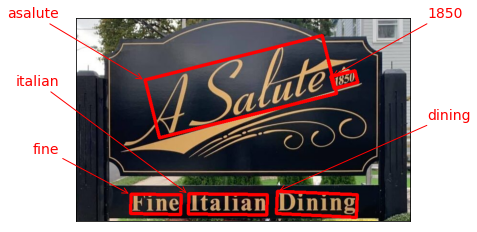

[Google OCR]
Texts:

"A Salute
1850
Fine Italian Dining
"

"A"

"Salute"

"1850"

"Fine"

"Italian"

"Dining"
bounds: (420,364),(579,365),(579,407),(420,406)
[Tesseract]

HITS

itearen

ay

Bie

|

Done


In [16]:
compare_ocr('tilted_1.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


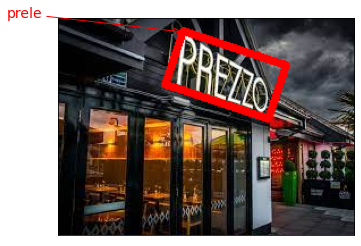

[Google OCR]
Texts:

"PREZO.
"

"PREZO."
bounds: (115,17),(202,56),(185,94),(98,55)
[Tesseract]


SystemError: tile cannot extend outside image

In [17]:
compare_ocr('tilted_2.jfif')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


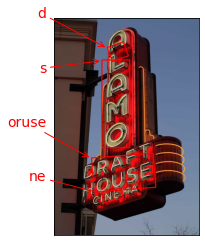

[Google OCR]
Texts:

"DRAFT
HOUSE
CINEMA
"

"DRAFT"

"HOUSE"

"CINEMA"
bounds: (233,1099),(499,1022),(512,1068),(246,1145)
[Tesseract]
a4

Done


In [18]:
compare_ocr('vertical.jpg')

## Step4. 결과 분석과 결론 제시
- big_small_letters(작고 큰 글자가 섞여있고, 글자 간 간격이 일정하지 않을 때)
 - 세 가지 OCR 모두 wings, shrimp, burgers와 같이 간격이 일정하고 또렷한 각도의 글씨를 정확히 인식했다.
 - keras-ocr의 경우 HOOTERS 글씨 간격이 일정하지 않아서 HOOTERS를 제대로 인식하지 못했다.
 - 구글 OCR은 HOOTERS를 정확히 인식했다.
 - tesseract는 HOOTERS의 TERS부분을 Ted로 인식한 것 같다.
 - 구글OCR은 정확했고 keras-ocr의 경우 HOOTERS를 쪼개서 ha ters라고 인식해, HOOTERS의 일부분만 ted로 인식한 tesseract보다 낫다고 생각한다.
 - 따라서, 글자 간 간격이 일정하지 않을 때, 구글OCR > keras-ocr > tesseract 순으로 성능이 좋다. 
- below( 각도를 아래에서 찍은 간판)
 - 구글 OCR의 경우 "McDonald's BILLIONS AND BILLIONS SERVED DRIVE-THRU'를 대소문자 구분까지 명확하게 정확히 인식했다. 각도에도 안정적으로 인식하는 것을 확인해주었다.
 - keras-ocr은 McDonald's를 donalgs, saes로 인식하였고 drive thru 외의 다른 글자는 정확하게 인식하지 못하였다.
 - tesseract는 어떠한 글자도 제대로 뽑아내지 못하고 - 42a!와 같이 엉뚱하게 인식하였다.
 - 따라서, 아래에서 글자를 바라보는 것과 같이 각도가 틀어졌을 때 구글OCR > keras-ocr > tesseract 순으로 성능이 좋다. 
- round(정글자가 아닌 필기체의 글자, 글자가 원 모양으로 배치되어 있을 때)
 - 구글 OCR이 food나 drink와 같이 글자가 원 모양으로 둥글게 배치되어 았을 때 drink를 orink로 인식하였고, 필기체로 되어있는 restaurant를 rostaurant로 인식한다.
 - keras-ocr은 food와 drink를 정확히 인식하여 글자모양이 둥글게 배치되어 있을 때 stable한 것을 알게되었다. 그러나, 필기체를 ristawaunt로 인식해 필기체에는 취약한 것을 알게 되었다.
 - tesseract는 SystemError: tile cannot extend outside image가 뜬다. 이미지밖에 글자가 있는 것으로 인식하는 것으로 보아, restaurant글자가 길게 옆으로 늘어져있는 것을 못잡고 이미지의 frame을 작게 잡아준건가 싶다.
 -  따라서, 필기체의 경우 구글OCR > keras-ocr > tesseract 순으로 성능이 좋고, 둥글게 배치된 글자의 경우 keras-ocr > 구글OCR > tesseract 순으로 성능이 좋다.
- easy_to_read(비교적 각도도 정면에서 바라보고 글자 간 간격도 일정하며, 인식하기 쉽다고 생각한 간판)
 - 구글 OCR은 정확히 인식하였다.
 - keras-ocr의 경우 나머지는 정확히 인식하였으나, &와 같은 특수 문자를 인식하는 데에 어려움이 있어보인다. BAR &를 barig로 인식했기 때문이다.
 - 비교적 읽기 쉽다고 생각한 간판조차 tesseract는 어떠한 글자도 제대로 뽑아내지 못하였다.
- thick_letters(안이 비어있는 글자)
 - 구글 OCR은 LATE NIGHT RAMEN을 정확히 인식했다.
 - keras-ocr은 ramen을 정확히 인식하였으나, late와 night를 정확히 인식하지 못한 것으로 보아, 안이 비어있는 글자를 인식할 때 어려움이 있는 것같다.
 - tesseract는 어떠한 글자도 제대로 뽑아내지 못하였다.
- tilted 1(2차원으로 기울어져 있을 때)
 - 구글 OCR은 "A Salute 1850 Fine Italian Dining"을 띄어쓰기와 대소문자까지 완벽하게 구분해내었다.
 - keras-ocr은 asolute의 띄어쓰기를 구분하지 못하였으나, 나머지 부분은 정확하게 인식하였다.
 - tesseract는 어떠한 단어도 정확하게 뽑아내지 못하였으나 italian을 itearen으로 그나마 비슷하게 알아냈다.
 - 글자가 기울어져있을 때 역시 구글OCR > keras-ocr > tesseract 순으로 성능이 좋다.
- tilted 2(3차원으로 기울어져 있을 때)
 - 구글 OCR은 PREZZO를 PREZO로 인식하였다. 성능이 가장 좋은 구글 OCR조차 3차원으로 기울어져 있을 때 인식에 어려움이 있는 것을 알 수 있다. ZZ를 Z로 인식했기 때문에 어쩌면 반복되는 글자에 취약한 것일 수도 있다.
 - keras-ocr은 PREZZO를 prele로 인식하였다. 
 - tesseract는 SystemError: tile cannot extend outside image가 떠서 이미지 frame잡는 것에서부터 버벅거리는 것을 확인할 수 있다.
 - 전반적으로 3차원으로 기울어져 있을 때 인식이 어렵다는 사실을 알 수 있었다.
- vertical(글자가 세로로 놓여있을 때)
 - 구글 OCR이 ALAMO라는 세로로 놓여있는 글자를 인식하지 못하였다. 세로로 쓰여있는 글자를 인식해야 할 땐, 구글 OCR이 적합하지 않다는 것을 알 수 있었다.
 - keras-ocr은 언뜻보면 세로로 글자가 놓여있다는 사실을 인식하는 듯하나, ALAMO를 d와 s로 인식하는 것으로 보아, 세로로 글자를 인식하지 못한다는 점은 구글 OCR과 같다는 것을 알 수 있다. 그러나, 세로로 된 글자의 frame은 잡아주는 것으로 보아, 조금 더 보안을 한다면 세로로 된 글자에 있어서만큼은 구글OCR보다 성능 좋게 구현할 가능성을 보았다.
 - tesseract는 전체 간판에서 a4를 잡아낸 것으로 보아 역시 미흡하다는 것을 재확인하였다.
 
- 전반적으로 구글 OCR이 띄어쓰기도 가장 잘 잡아내고 대소문자까지 구분한다는 점에서 나머지 둘 OCR에 비해 성능이 좋다는 것을 알 수 있다. 그 뿐만 아니라, 대체적으로 정확하게 글씨를 잡아냈다. 다만, 3차원으로 기울어진 문자를 인식하는 데에는 다소 취약하다는 아쉬움이 있다. 또한 세로로 된 글자는 아예 인식 못한다는 점도 흠이 될 수 있다. 다행히, 대부분의 음식점 간판의 글씨들은 가로로 글자가 써있다는 점을 감안하면, 구글 OCR은 음식점 간판을 읽는 데에 상당히 적합하다.
- keras-ocr은 모든 문자를 소문자로 인식하지만, 이는 큰 문제가 되지 않는다. 음식점의 이름을 알아내는 것이 관건이기 때문이다. 하지만, 대체적으로 정확도가 많이 떨어졌고,&와 같은 특수문자를 아예 인식하지 못하는 거였으면 차라리 다행이었겠지만 다른 알파벳으로 인식한다는 점도 정확도를 낮추는 요인이 되었다. 가장 중요한 점은 정확도가 떨어졌기 때문에 음식점 간판을 인식하는 사업에 적용하기에는 무리가 있다고 판단된다.
- tesseract는 정확도를 논하기에 민망할 정도로 거의 대부분 단어들을 인식하지 못하였고, 심지어 가끔씩은 단어가 있는 부분의 frame조차 제대로 잡아주지 못해 SystemError: tile cannot extend outside image가 뜬다. tesseract는 아직 상용화와 거리가 많이 멀어보인다.